# Checking if scyan is installed

In [1]:
try:
    import scyan
    print("scyan is installed.")
except ImportError:
    print("scyan is not installed. Installing now...")
    !pip install scyan

Seed set to 0


scyan is installed.


In [4]:
import anndata
from pathlib import Path
import pandas as pd
import time
import matplotlib.pyplot as plt

# Concaténation de fichier FSC (WT1)

In [5]:
# Load and preprocess IDHm2-191442 data
folder_path = Path(r"C:/Users/anush/Desktop/M1 BME/S2/stage/fcs_data/IDHm2-191442")
fcs_paths = [path for path in folder_path.iterdir() if path.suffix == ".fcs"]

def read_one(path):
    adata_IDHm2_191442 = scyan.read_fcs(path)
    adata_IDHm2_191442.obs["file"] = path.stem
    adata_IDHm2_191442.obs["batch"] = "NA"
    return adata_IDHm2_191442

adata_IDHm2_191442 = anndata.concat([read_one(p) for p in fcs_paths], index_unique="-")

# Preprocessing 

In [6]:
is_cytof = True

if is_cytof:
    scyan.preprocess.asinh_transform(adata_IDHm2_191442)
else:
    scyan.preprocess.auto_logicle_transform(adata_IDHm2_191442)

scyan.preprocess.scale(adata_IDHm2_191442)

[INFO] (scyan.preprocess) Data will be standardised, and translated so that 0 goes to -1. This is advised only when using CyTOF data (if this is not your case, consider running 'auto_logicle_transform' instead of 'asinh_transform').


# Knowledge table

In [7]:
file_path = 'C:/Users/anush/Desktop/M1 BME/S2/stage/Report/Table_ref_V2.csv'
table = pd.read_csv(file_path, index_col=[0, 1])

# Sanity check

In [9]:
# Check for missing markers
missing_markers = [col for col in table.columns if col not in adata_IDHm2_191442.var_names]
if missing_markers:
    print("Markers in table.columns not present in adata_IDHm2_191442.var_names:")
    print(missing_markers)
else:
    print("All markers in table.columns are present in adata_IDHm2_191442.var_names.")

All markers in table.columns are present in adata_IDHm2_191442.var_names.


# Duplicate checking

In [8]:
# Check for duplicate rows based on the markers expression
duplicates = table[table.duplicated(keep=False)]

if not duplicates.empty:
    print("Duplicate rows found based on marker expressions:")
    print(duplicates)
else:
    print("No duplicates found based on marker expressions.")

No duplicates found based on marker expressions.


# Timepoint function

In [10]:
# Map time points and treatments
def map_time_point(filename):
    parts = filename.split('_')
    if len(parts) >= 2:
        day = parts[1]  # Extract day (e.g., "Day0", "Day7", "Day10")
        return day
    return 'Unknown'

def map_treatment(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        treatment = parts[2]  # Extract treatment if available
        return treatment
    return 'None'

adata_IDHm2_191442.obs["time_point"] = adata_IDHm2_191442.obs["file"].map(map_time_point)
adata_IDHm2_191442.obs["treatment"] = adata_IDHm2_191442.obs["file"].map(map_treatment)

adata_IDHm2_191442.obs["time_point"] = pd.Categorical(
    adata_IDHm2_191442.obs["time_point"],
    categories=["Day0", "Day7", "Day10"],
    ordered=True
)

print("Unique time points (with order):")
print(adata_IDHm2_191442.obs["time_point"].unique())
print("Unique treatments:")
print(adata_IDHm2_191442.obs["treatment"].unique())

print(adata_IDHm2_191442.obs.head(8))

Unique time points (with order):
['Day10', 'Day7']
Categories (3, object): ['Day0' < 'Day7' < 'Day10']
Unique treatments:
['AG221' 'DMSO' 'G10' 'G25' 'G50']
     Time     SSC-H         SSC-A     FSC-H        FSC-A   SSC-B-H  \
0-0   0.0  574366.0  1.036031e+06  572732.0   926981.750  524559.0   
1-0   2.0  515012.0  7.157668e+05  789305.0  1072475.500  438025.0   
2-0   4.0  613370.0  1.001266e+06  852436.0  1302447.000  528321.0   
3-0   8.0  655149.0  9.536238e+05  600297.0   852180.875  592718.0   
4-0  16.0  564678.0  9.422459e+05  850622.0  1345198.375  426015.0   
5-0  19.0  760133.0  1.020958e+06  751051.0   942861.125  607515.0   
6-0  20.0  556189.0  8.341489e+05  704451.0   992093.500  467199.0   
7-0  24.0  596684.0  9.862960e+05  948662.0  1552625.125  527596.0   

         SSC-B-A           PU1         CEBPA        GATA2  ...  new color 8-A  \
0-0  872675.0000   5970.039551  29543.044922  2322.983154  ...  -12208.078125   
1-0  556009.1875   -352.898071  14643.833008   589

# UMAP

In [11]:
# UMAP dimension reduction
start_time = time.time()
scyan.tools.umap(adata_IDHm2_191442, markers=table.columns)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps écoulé pour le calcul de l'UMAP : {elapsed_time:.2f} seconds")

[INFO] (scyan.tools.representation) Fitting UMAP...


Temps écoulé pour le calcul de l'UMAP : 249.09 seconds


# Saving the Scyan Project

In [12]:
# Save project
scyan.data.add("IDHm2-191442", adata_IDHm2_191442, table)

[INFO] (scyan.data.datasets) Creating new dataset folder at C:\Users\anush\.scyan_data\IDHm2-191442
[INFO] (scyan.data.datasets) Created file C:\Users\anush\.scyan_data\IDHm2-191442\default.h5ad
[INFO] (scyan.data.datasets) Created file C:\Users\anush\.scyan_data\IDHm2-191442\default.csv


# Loading the Scyan project

In [14]:
adata_IDHm2_191442, table = scyan.data.load("IDHm2-191442")

# Model fitting

In [15]:
# Initialize and fit the model
model_IDHm2_191442 = scyan.Scyan(adata_IDHm2_191442, table)
model_IDHm2_191442.fit()

[INFO] (scyan.model) Initialized Scyan model with N=3115584 cells, P=28 populations and M=25 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False
[INFO] (scyan.model) Training scyan with the following hyperparameters:
"batch_key":       None
"batch_size":      8192
"hidden_size":     16
"lr":              0.0005
"max_samples":     200000
"modulo_temp":     3
"n_hidden_layers": 6
"n_layers":        7
"prior_std":       0.3
"temperature":     0.5
"warm_up":         (0.35, 4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type        | Params | Mode 
-----------------------------------------------
0 | module | ScyanModule | 34.6 K | train
-----------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.139     Total estimated model params size (MB)
243       Modules in train mode
0         

Training: |                                                                                      | 0/? [00:00<…

[INFO] (scyan.model) Ended warm up epochs
[INFO] (scyan.model) Successfully ended training.


Scyan model with N=3115584 cells, P=28 populations and M=25 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False

# 1st prediction

In [16]:
# Predict with the model
model_IDHm2_191442.predict()

DataLoader:   0%|          | 0/381 [00:00<?, ?it/s]

[WARNING] (scyan.model) 13 population(s) were not predicted. It may be due to:
  - Errors in the knowledge table (see https://mics-lab.github.io/scyan/advice/#advice-for-the-creation-of-the-table)
  - The model hyperparameters choice (see https://mics-lab.github.io/scyan/advanced/parameters/)
  - Or maybe these populations are really absent from this dataset.


0          Granulocytes
1          Granulocytes
2          Granulocytes
3          Granulocytes
4          Granulocytes
               ...     
3115579             pDC
3115580        Plasma B
3115581    Granulocytes
3115582       Basophils
3115583             pDC
Length: 3115584, dtype: category
Categories (15, object): [' CD45RA+ Memory Effector T cell', 'Basophils', 'Central Memory T cell', 'Erythrocytes_CD45+', ..., 'Plasma B', 'Promonocytes', 'Transitional & Memory effector T cell', 'pDC']

# Checking the threshold

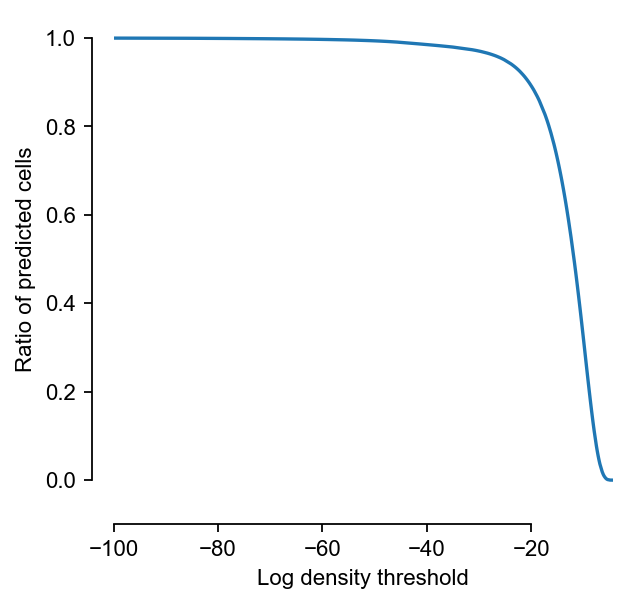

In [17]:
# Plot log probability threshold
scyan.plot.log_prob_threshold(adata_IDHm2_191442)
plt.show()

# UMAP visualization

In [18]:
threshold = -20
# Predict with the model
model_IDHm2_191442.predict(log_prob_th=threshold)

DataLoader:   0%|          | 0/381 [00:00<?, ?it/s]

[WARNING] (scyan.model) 13 population(s) were not predicted. It may be due to:
  - Errors in the knowledge table (see https://mics-lab.github.io/scyan/advice/#advice-for-the-creation-of-the-table)
  - The model hyperparameters choice (see https://mics-lab.github.io/scyan/advanced/parameters/)
  - Or maybe these populations are really absent from this dataset.


0          Granulocytes
1          Granulocytes
2          Granulocytes
3          Granulocytes
4          Granulocytes
               ...     
3115579             NaN
3115580             NaN
3115581             NaN
3115582             NaN
3115583             NaN
Length: 3115584, dtype: category
Categories (15, object): [' CD45RA+ Memory Effector T cell', 'Basophils', 'Central Memory T cell', 'Erythrocytes_CD45+', ..., 'Plasma B', 'Promonocytes', 'Transitional & Memory effector T cell', 'pDC']

# Palette

In [19]:
# Define the color palettes for UMAP visualization
# Define the updated unique color palette for UMAP visualization
color_palette = {
    'LSC_CD34+_CD117+': '#D9534F',         # Red
    'LSC_CD34+_CD117-': '#C8102E',         # Dark Red
    'LSC_CD34-_CD117+': '#B02E26',         # Crimson
    'LSC_CD34-_CD117-': '#A7322A',         # Dark Crimson
    'HSC_CD117+': '#1E88E5',               # Blue
    'HSC_CD117-': '#1976D2',               # Dark Blue
    'CD34+CD38+CD123+ HSPCs': '#66BB6A',   # Light Green
    'CMP': '#4CAF50',                      # Green
    'MEP': '#43A047',                      # Dark Green
    'GMP': '#388E3C',                      # Olive Green
    'pDC': '#5C6BC0',                     # Medium Blue
    'NK': '#26A69A',                      # Teal
    'NK-CD62L-': '#004D40',               # Dark Teal
    'B cells': '#FFCA28',                 # Yellow
    'Plasma B': '#FFB300',                # Amber
    'Granulocytes': '#90A4AE',            # Grey
    'Basophils': '#78909C',               # Blue Grey
    'Naive T cells': '#AB47BC',           # Purple
    'CD45RA+ Memory Effector T cell': '#9C27B0', # Dark Purple
    'Central Memory T cell': '#8E24AA',   # Medium Purple
    'Transitional & Memory effector T cell': '#7B1FA2', # Deep Purple
    'Erythrocytes_CD45+': '#E57373',      # Light Coral
    'Erythrocytes_CD45-': '#F44336',      # Red
    'CD11B+_Monocytes': '#BCAAA4',        # Light Brown
    'CD11B+_Monocytes*': '#A1887F',       # Medium Brown
    'Promonocytes': '#D7CCC8',            # Beige
    'Mono_Myeloblastes_CD15+': '#7CB342', # Olive Drab
    'Mono_Myeloblastes_CD15-': '#9CCC65', # Light Olive
}

# Define the updated hierarchical color palette
hierarchy_palette = {
    'LSC': '#D9534F',                    # Red
    'HSC': '#1E88E5',                    # Blue
    'Progenitors': '#66BB6A',            # Light Green
    'Dendritic': '#5C6BC0',              # Medium Blue
    'NK': '#26A69A',                    # Teal
    'B Cells': '#FFCA28',               # Yellow
    'Myeloid': '#90A4AE',               # Grey
    'T Cells': '#AB47BC',               # Purple
    'Erythrocytes': '#E57373',          # Light Coral
    'Monocytes': '#BCAAA4',             # Light Brown
    'NKCD62L-': '#004D40',              # Dark Teal
}

# UMAP level plotting

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


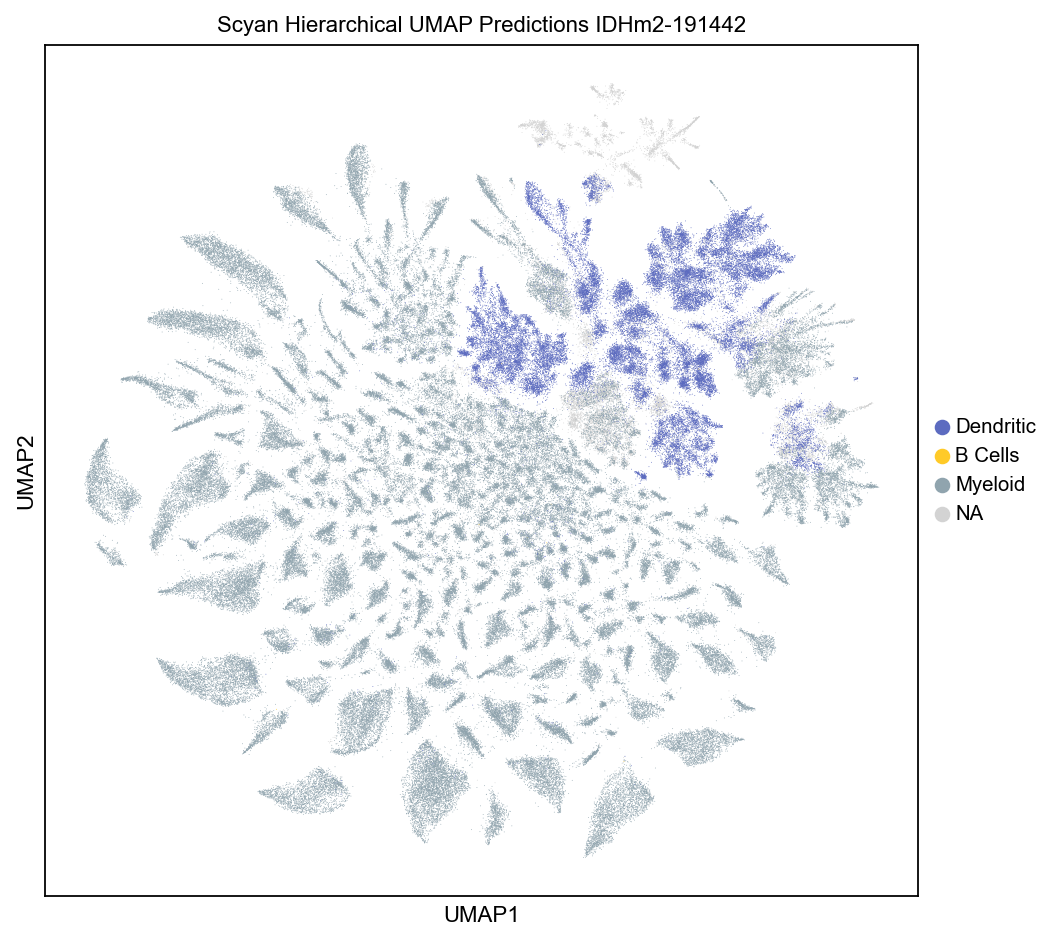

In [20]:
# Plot UMAP with hierarchical color palette
fig, ax = plt.subplots(figsize=(7, 7))
scyan.plot.umap(adata_IDHm2_191442, color="scyan_pop_level", ax=ax, title="Scyan Hierarchical UMAP Predictions IDHm2-191442", palette=hierarchy_palette)
plt.show()

# UMAP plotting (normal)

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


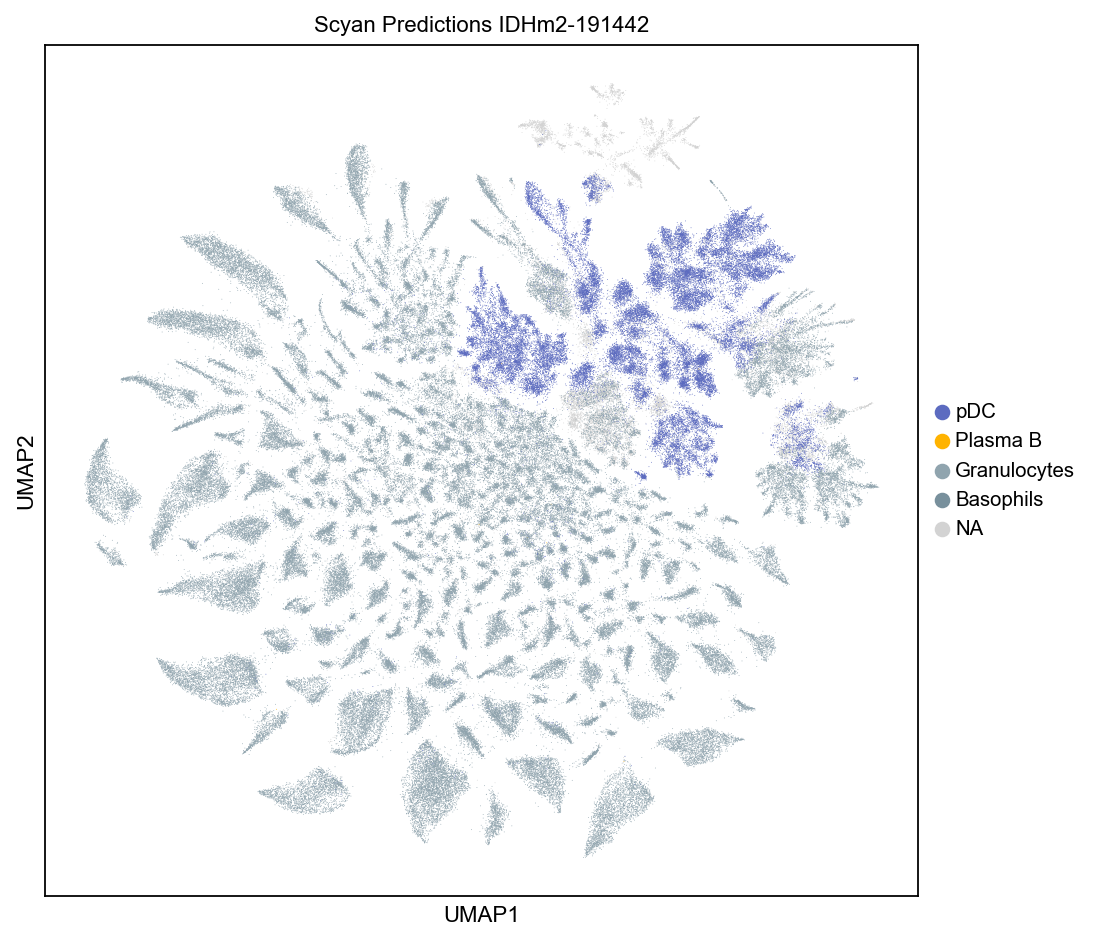

In [21]:
# Plot UMAP with standard color palette
fig, ax = plt.subplots(figsize=(7, 7))
scyan.plot.umap(adata_IDHm2_191442, color="scyan_pop", ax=ax, title="Scyan Predictions IDHm2-191442", palette=color_palette)
plt.show()

# UMAP for each file

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


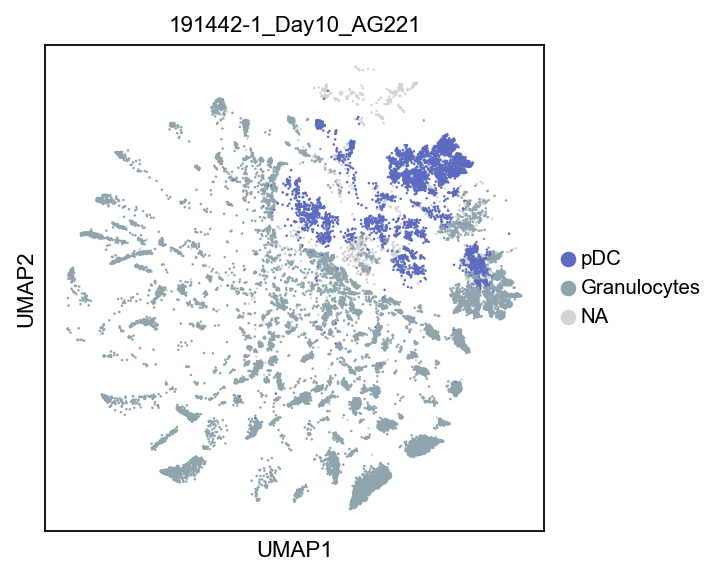

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


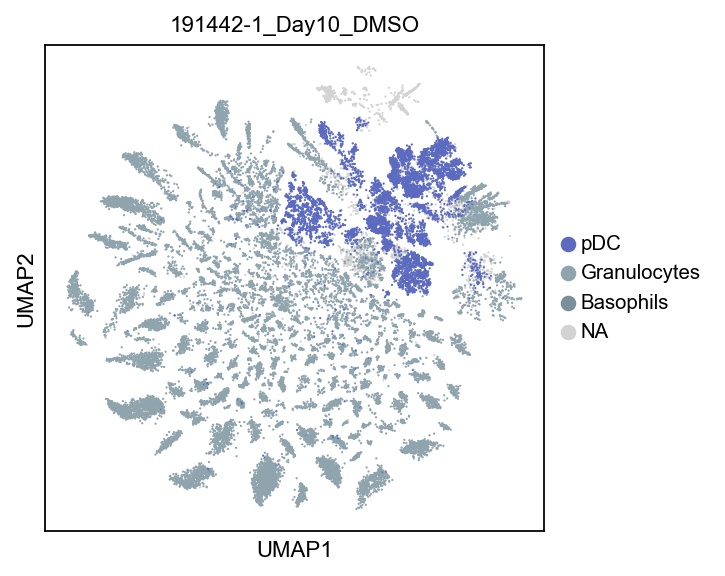

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


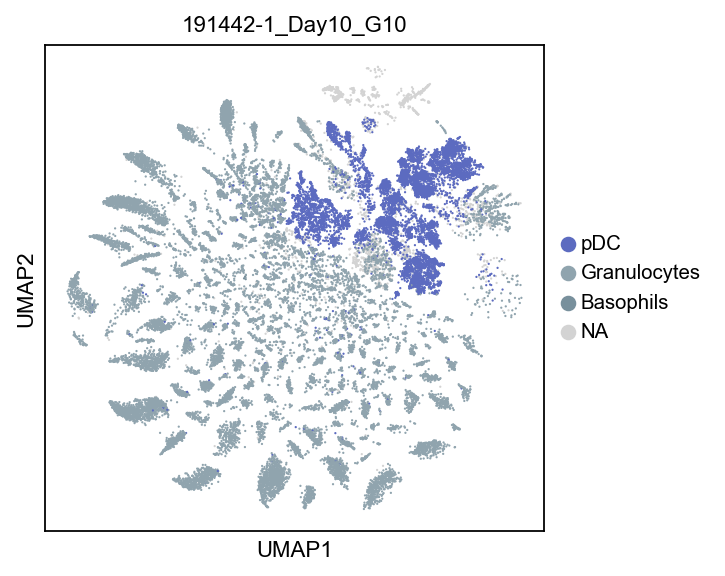

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


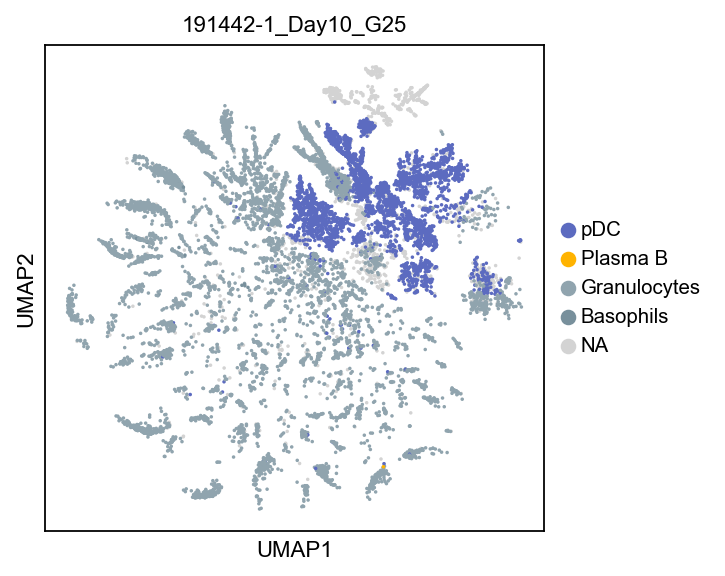

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


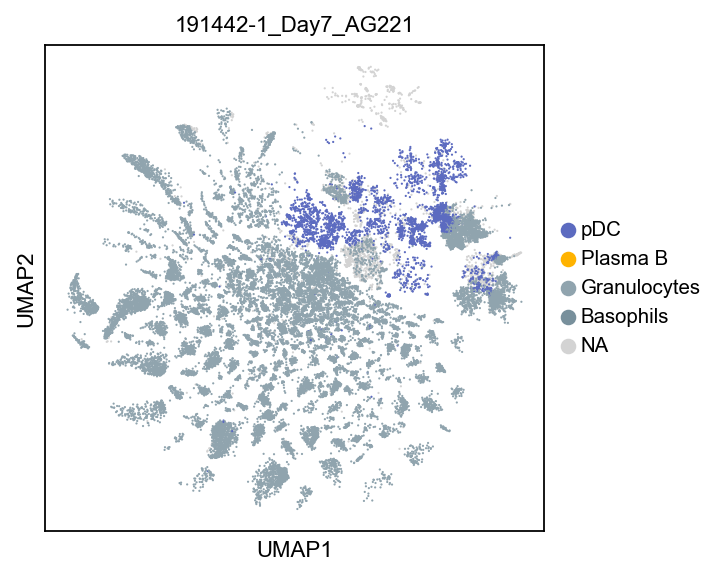

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


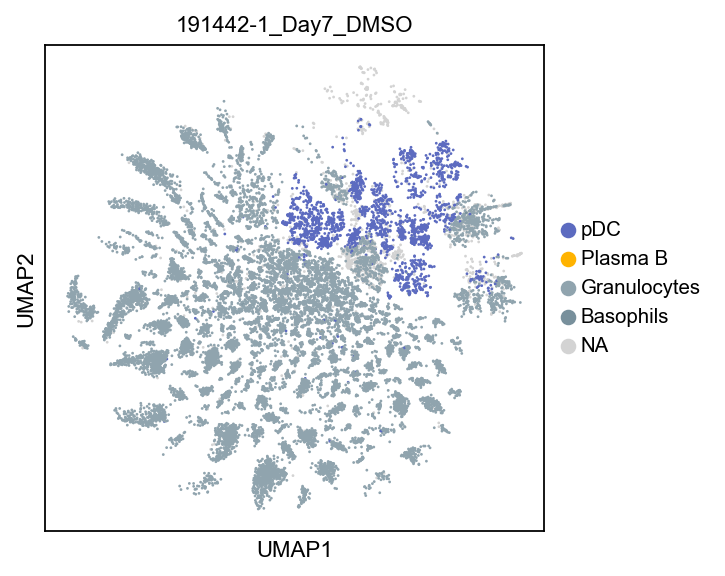

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


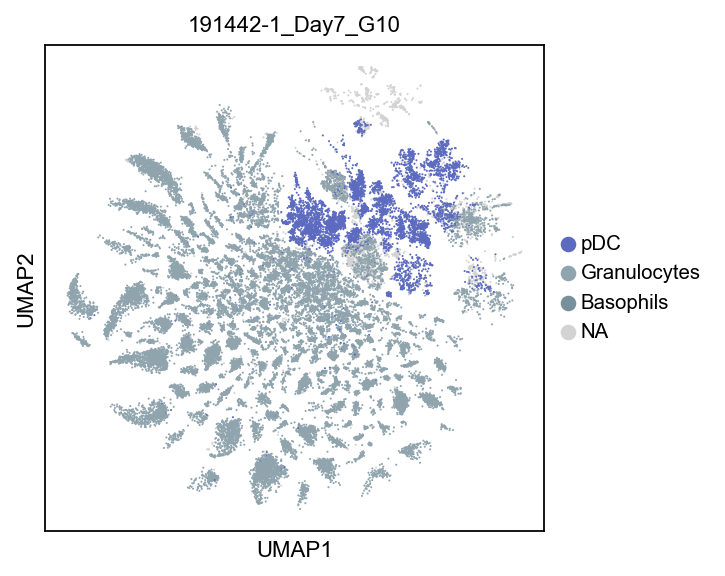

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


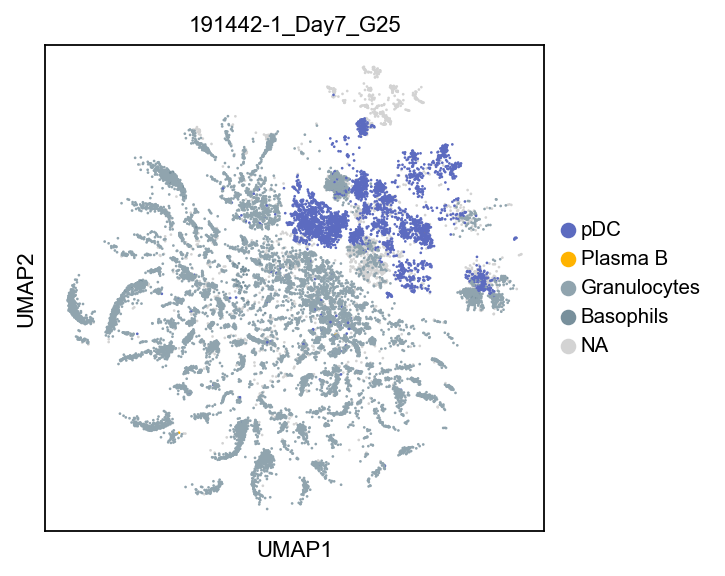

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


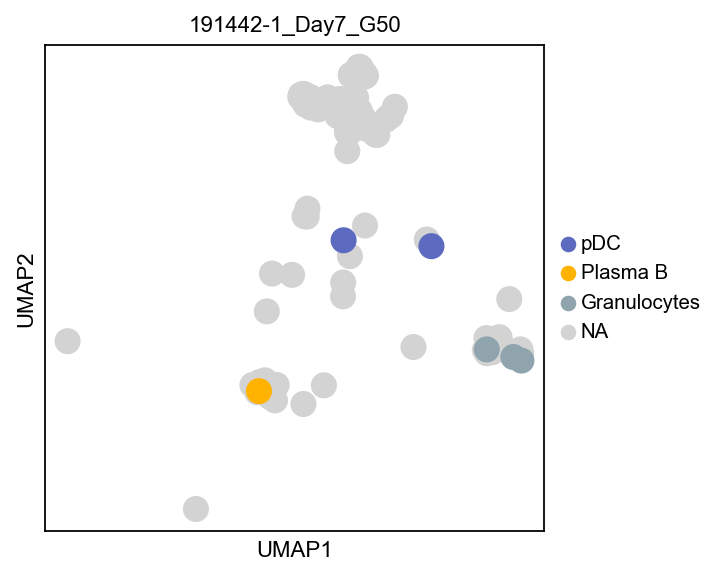

In [25]:
import numpy as np
import scyan

# Loop over each unique file in the 'file' column of the obs DataFrame for adata_IDHm2_191442
for filename in np.unique(adata_IDHm2_191442.obs["file"]):
    # Subset the data to include only the cells from the current file
    adata_one_file = adata_IDHm2_191442[adata_IDHm2_191442.obs["file"] == filename]
    
    # Plot the UMAP for the current subset of data
    scyan.plot.umap(adata_one_file, color="scyan_pop", title=filename, palette=color_palette)


C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\tools\biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\tools\biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\ratios.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

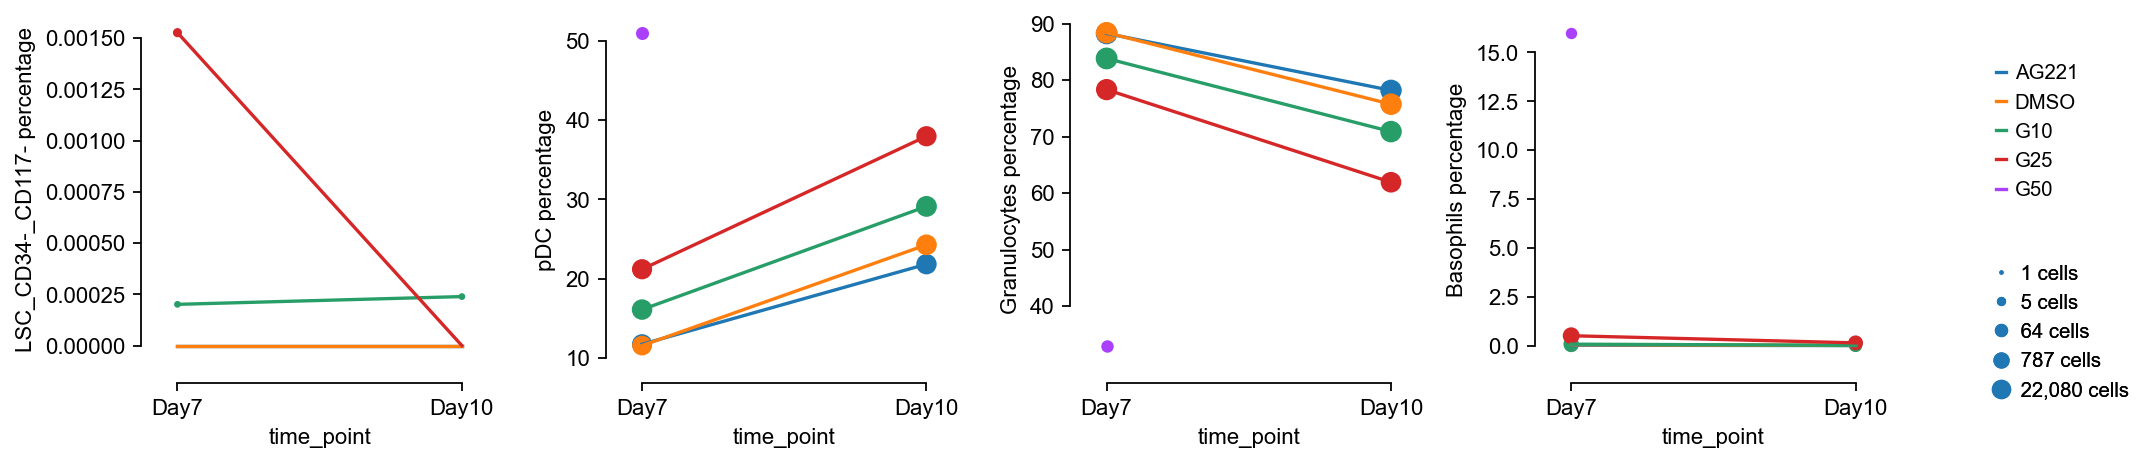

In [24]:
import scyan

# Define the myeloid cell populations of interest
myeloid_populations = [
    'Granulocytes',
    'Basophils',
    'CD11B+_Monocytes',
    'CD11B+_Monocytes*',
    'Promonocytes',
    'Mono_Myeloblastes_CD15+',
    'Mono_Myeloblastes_CD15-',
    'CMP',
    'MEP',
    'GMP',
    'Erythrocytes_CD45+',
    'Erythrocytes_CD45-',
    'LSC_CD34+_CD117+',
    'LSC_CD34+_CD117-',
    'LSC_CD34-_CD117+',
    'LSC_CD34-_CD117-',
    'pDC'
]

# Filter the AnnData object to include only the myeloid populations
adata_myeloid = adata_IDHm2_191442[adata_IDHm2_191442.obs['scyan_pop'].isin(myeloid_populations)]

# Plot population dynamics for myeloid cells
scyan.plot.pop_dynamics(
    adata_myeloid,        # Use the filtered AnnData object
    time_key="time_point",  # Column name for time points
    groupby="treatment",    # Column name for grouping
    key="scyan_pop"         # Column name for cell populations
)
